# More APIs

## Low-level APIs: `tfplot.plot()`

The following examples show the usage of the most general form of the API, `tfplot.plot()`. It has a very similar usage as [tf.py_func()](https://www.tensorflow.org/api_docs/python/tf/py_func).

Conceptually, we can draw any matplotlib plot as a TensorFlow op. One thing to remember is that the `plot_func` function (passed to `tfplot.plot()`) should be implemented using object-oriented APIs of matplotlib, not `pyplot.XXX` APIs (or `matplotlib.pyplot.XXX`) in order to avoid thread-safety issues.

### A basic example

Executing: Tensor("Plot:0", shape=(?, ?, 4), dtype=uint8)


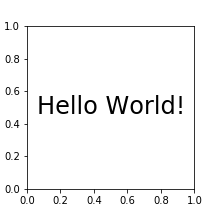

In [25]:
def test_figure():
    fig, ax = tfplot.subplots(figsize=(3, 3))
    ax.text(0.5, 0.5, "Hello World!",
            ha='center', va='center', size=24)
    return fig

plot_op = tfplot.plot(test_figure, [])
execute_op_as_image(plot_op)

### with Arguments

Executing: Tensor("Plot_1:0", shape=(?, ?, 4), dtype=uint8)


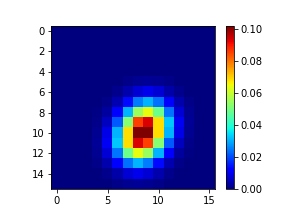

In [26]:
def figure_attention(attention):
    fig, ax = tfplot.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig

plot_op = tfplot.plot(figure_attention, [attention_tensor])
execute_op_as_image(plot_op)

### Examples of using kwargs

In [27]:
# the plot function can have additional kwargs for providing configuration points
def overlay_attention(attention, image,
                      alpha=0.5, cmap='jet'):
    fig = tfplot.Figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    fig.subplots_adjust(0, 0, 1, 1)  # get rid of margins
    
    H, W = attention.shape
    ax.imshow(image, extent=[0, H, 0, W])
    ax.imshow(attention, cmap=cmap,
              alpha=alpha, extent=[0, H, 0, W])
    return fig

Executing: Tensor("Plot_2:0", shape=(?, ?, 4), dtype=uint8)


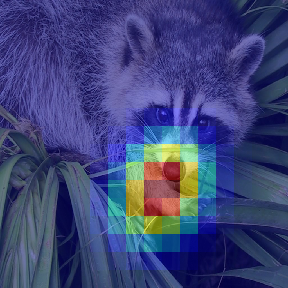

In [28]:
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor])
execute_op_as_image(plot_op)

Executing: Tensor("Plot_3:0", shape=(?, ?, 4), dtype=uint8)


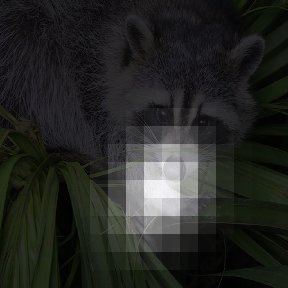

In [29]:
# the kwargs to `tfplot.plot()` are passed to the plot function (i.e. `overlay_attention`)
# during the execution of the plot operation.
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor],
                      cmap='gray', alpha=0.8)
execute_op_as_image(plot_op)

### `plot_many()` -- the batch version

In [30]:
# make a fake batch
batch_size = 3
attention_batch = tf.random_gamma([batch_size, 7, 7], alpha=0.3, seed=42)
image_batch = tf.tile(tf.expand_dims(image_tensor, 0),
                      [batch_size, 1, 1, 1], name='image_batch')
print (attention_batch)
print (image_batch)

# plot_many()
plot_op = tfplot.plot_many(overlay_attention, [attention_batch, image_batch])
images = execute_op_as_image(plot_op)

Tensor("random_gamma/Maximum:0", shape=(3, 7, 7), dtype=float32)
Tensor("image_batch:0", shape=(3, 768, 1024, 3), dtype=uint8)
Executing: Tensor("PlotMany/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


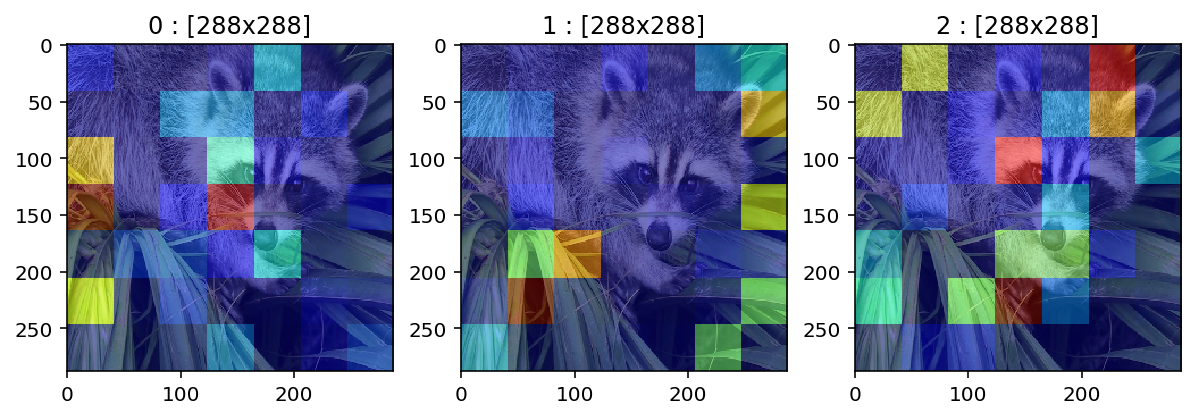

In [31]:
# just see the three images
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i].imshow(images[i])
plt.show()

### Wrap once, use it as a factory -- `tfplot.autowrap()` or `tfplot.wrap()`

Let's wrap the function `overlay_attention`, which

* takes a heatmap `attention` and a RGB image `overlay_image`
* and plots the heatmap on top of the image

as Tensors:

Executing: Tensor("overlay_attention:0", shape=(?, ?, 4), dtype=uint8)


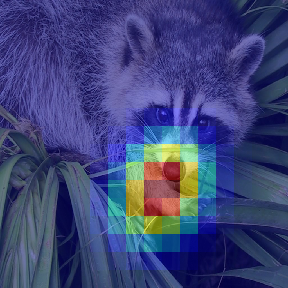

In [32]:
plot_op = tfplot.autowrap(overlay_attention)(attention_tensor, image_tensor)
execute_op_as_image(plot_op)

More clean style in a functional way!

### Batch example

In [33]:
tf_plot_attention = tfplot.wrap(overlay_attention, name='PlotAttention', batch=True)
print (tf_plot_attention)

<function wrap[__main__.overlay_attention] at 0x127f26f28>


Then we can call the resulting `tf_plot_attention` function to build new TensorFlow ops:

In [34]:
plot_op = tf_plot_attention(attention_batch, image_batch)
images = execute_op_as_image(plot_op)
images

Executing: Tensor("PlotAttention/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


[<PIL.Image.Image image mode=RGBA size=288x288 at 0x12A896470>,
 <PIL.Image.Image image mode=RGBA size=288x288 at 0x12A896390>,
 <PIL.Image.Image image mode=RGBA size=288x288 at 0x12A8962E8>]

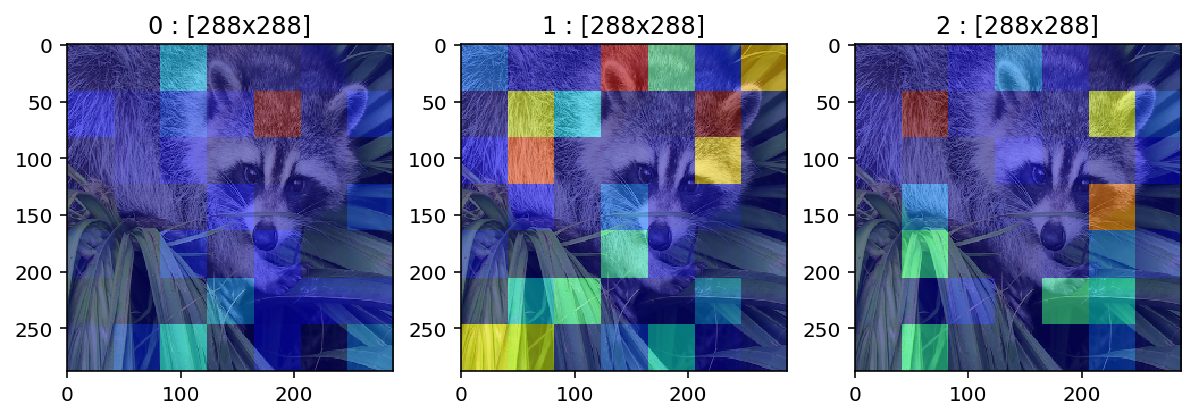

In [35]:
# just see the three images
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i].imshow(images[i])
plt.show()

<br/><br/><br/><br/>

## `tfplot.summary` (deprecated)

Finally, we can directly create a TensorFlow summary op from input tensors. This will give a similar API usage as `tf.summary.image()`, which is a shortcut to creating plot ops and then creating image summaries.

In [36]:
import tfplot.summary

### `tfplot.summary.plot()`

Tensor("plot_summary/ImageSummary:0", shape=(), dtype=string)
Executing: Tensor("plot_summary/ImageSummary:0", shape=(), dtype=string)


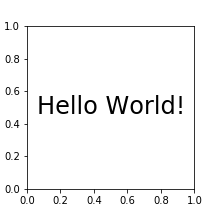

In [37]:
# Just directly add a single plot result into a summary
summary_op = tfplot.summary.plot("plot_summary", test_figure, [])
print(summary_op)
execute_op_as_image(summary_op)

### `tfplot.summary.plot_many()` -- the batch version

In [38]:
# batch of attention maps --> image summary
batch_size, H, W = 4, 4, 4
batch_attentions = np.zeros((batch_size, H, W), dtype=np.float32)
for b in range(batch_size):
    batch_attentions[b, b, b] = 1.0
    
# Note that tfplot.summary.plot_many() takes an input in a batch form
def figure_attention_demo2(attention):
    fig, ax = tfplot.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig
summary_op = tfplot.summary.plot_many("batch_attentions_summary", figure_attention_demo2,
                                      [batch_attentions], max_outputs=4)
print(summary_op)
images = execute_op_as_image(summary_op)

Tensor("batch_attentions_summary/ImageSummary:0", shape=(), dtype=string)
Executing: Tensor("batch_attentions_summary/ImageSummary:0", shape=(), dtype=string)


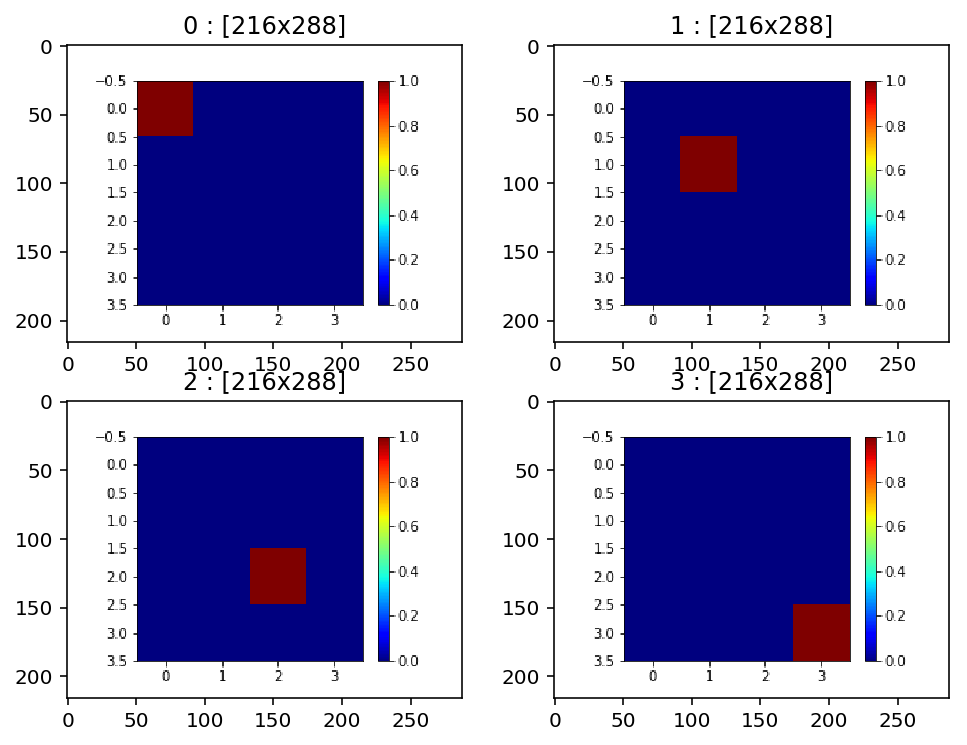

In [39]:
# just see the 4 images in the summary
_, axes = plt.subplots(2, 2, figsize=(8, 6))
for i in range(batch_size):
    axes[i//2, i%2].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i//2, i%2].imshow(images[i])
plt.show()